#  Task 2 : The Rise of the WeatherMind

#### **Level 1: Awakening WeatherMind**

####  Objective
- Construct a LangGraph node called `chatbot`, powered by a Language Model (Groq used in this case).
- Integrate a companion tool: the `calculator`, supporting basic arithmetic with BODMAS logic.
- Visualize the LangGraph as an image—representing the AI skeleton coming to life.


In [227]:
!pip install langgraph langsmith


In [228]:
!pip install langchain langchain_groq langchain_community

In [229]:
!pip install python-dotenv --quiet

# Import load_dotenv and os
from dotenv import load_dotenv
import os

# Load the .env file (make sure it’s uploaded in current directory)
load_dotenv('.env')
## Now read your API key (replace Groq_API_KEY with your variable name)
api_key = os.getenv('Groq_API_KEY')
# Now read your API key (replace WEATHER_API_KEY with your variable name)
weather_api_key = os.getenv('Weather_API_KEY')



In [230]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END  # StateGraph manages the state of all the agents
from langgraph.graph.message import add_messages # as we keep on adding messages the state of agent goes on changing

#### Calculator Tool: The Logic Unit

A custom calculator tool is added, enabling the AI to perform basic arithmetic operations following BODMAS rules. It allows the chatbot to solve user-inputted math queries.


In [231]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition


In [232]:
def safe_eval(expr: str) -> float:
    """
    Safely evaluate a basic arithmetic expression using BODMAS rules.
    """
    import math

    allowed_names = {
        k: v for k, v in vars(math).items() if not k.startswith("__")
    }

    allowed_names.update({
        'abs': abs,
        'round': round
    })

    try:
        result = eval(expr, {"__builtins__": None}, allowed_names)
        return result
    except Exception as e:
        return f"Error: {str(e)}"


In [233]:
@tool
def calculator(expression: str) -> str:
    """Evaluate a basic arithmetic expression. Supports +, -, *, /, (), and **."""
    result = safe_eval(expression)
    return str(result)

In [234]:
tools = [calculator]

#### Calculator Tool Test

We test the calculator tool with a sample arithmetic query to ensure it correctly evaluates expressions using BODMAS rules. The output confirms the tool is functioning as expected within the LangGraph framework.


In [235]:
calculator.invoke("5/2*4+3")

'13.0'

In [236]:
#Langgraph application
class State(TypedDict) :
  # Messages have the type "list" The `add_messages` function
  #in the annotation defines how this state key should be updated
  # ( in this case, it apends messages to the list , rather than overwriting them)
  messages: Annotated[list,add_messages]

In [237]:
graph_builder= StateGraph(State)

#### Chatbot Node using Groq LLM

We define a `chatbot` node using the Groq-hosted LLM, which serves as the core conversational engine for WeatherMind. It handles natural language input and determines the required tool or response logic.


In [238]:
from langchain_groq import ChatGroq

In [239]:
llm = ChatGroq(api_key = api_key , model_name = "Gemma2-9b-It" )
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7903995c9490>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7903995c91d0>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [240]:
llm_with_tools = llm.bind_tools(tools=tools)

In [241]:
def chatbot(state:State) :

  return{"messages": [llm.invoke(state["messages"])]}

#### Groq Chatbot LLM: Solving General Queries

The `chatbot` node, powered by Groq's high-speed LLM, is capable of understanding and answering general user queries. It forms the core conversational layer of WeatherMind, handling natural language prompts with accurate and fast responses.

**Example:**  
> "Who is the president of India?"  
→ The chatbot responds using Groq's LLM without needing any tool invocation.


In [242]:
from langchain_core.messages import AIMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "q"]:
        print("Good Bye")
        break

    for event in graph.stream({'messages': [("user", user_input)]}, stream_mode="values"):
        # Each event is a dictionary like {'messages': [AIMessage(...)]}
        messages = event.get("messages", [])
        for msg in messages:
            if isinstance(msg, AIMessage) and msg.content.strip() and "<tool-use>" not in msg.content:
                print("Assistant:", msg.content.strip())


User: hi
Assistant: Hello! 👋 

How can I help you today? 😊
User: tell me a joke
Assistant: Why don't scientists trust atoms? 

Because they make up everything! 😄
User: who is president of india?
Assistant: The President of India is **Droupadi Murmu**. 

She assumed office on July 25, 2022.
User: explain LLM short
Assistant: LLM stands for **Large Language Model**. 

Think of it as a super-smart computer program trained on massive amounts of text data. This training allows it to understand and generate human-like text in response to a wide range of prompts and questions. 

Here's a breakdown:

* **Large:** LLMs have billions, sometimes even trillions, of parameters. These parameters are like the connections in a brain, allowing the model to learn complex patterns in language.
* **Language:**  LLMs are specifically designed to work with language. They can read, understand, and generate text in various forms like sentences, paragraphs, stories, and even code.
* **Model:**  LLMs are statis

#### LangGraph Wiring: Neural Pathways

Using LangGraph, we wire the chatbot and calculator tools into a functional graph. This represents the neural pathways of WeatherMind—enabling it to reason and act through structured flows.


In [243]:
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_edge(START,"chatbot")
tool_node=ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge("chatbot",END)


In [244]:
graph = graph_builder.compile()

#### Neural Graph Visualization

We render the LangGraph to visually depict the structure of nodes and their connections. This image showcases the “awakening” of WeatherMind—the architecture of its digital brain.

The following cell renders the graph and opens the image:


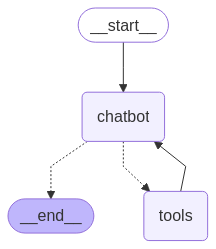

In [245]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

 **Level 1 Complete**  
WeatherMind is now alive with:
- A voice: powered by Groq’s LLM.
- A brain for math: via the BODMAS-aware calculator tool.
- A neural structure: visualized with LangGraph.


#### **Level 2: Senses of the World**  - Weather and Fashion Recommender


- **Fashion Recommender Tool:** Extracts location from queries and fetches real-time fashion trends using Google Trends.
- **Weather Extractor Tool:** Extracts location and retrieves current weather conditions via OpenWeatherMap API.
----







#### Extract Location and Detect Intent

This cell uses spaCy to extract geographical locations (GPE) from user queries. It also detects the user’s intent, whether they want weather information or fashion trends, by searching for keywords in the query.


In [246]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_location(query):
    doc = nlp(query)
    for ent in doc.ents:
        if ent.label_ == "GPE":
            return ent.text
    return None

def detect_intent(query):
    query = query.lower()
    if "weather" in query or "rain" in query or "sunny" in query:
        return "weather"
    elif "fashion" in query or "style" in query or "trend" in query:
        return "fashion"
    return None

#### Fetch Current Weather Data

This cell defines a function to fetch real-time weather data for a given location using the OpenWeatherMap API. It returns the current temperature and weather description.


In [247]:
import requests

def get_weather(location):

    url = f"http://api.openweathermap.org/data/2.5/weather?q={location}&appid={weather_api_key}&units=metric"

    try:
        response = requests.get(url)
        data = response.json()

        if response.status_code != 200:
            return {"error": f"{data.get('message', 'Weather data not found.')} (Status code: {response.status_code})"}

        return {
            "location": location,
            "temperature": data["main"]["temp"],
            "description": data["weather"][0]["description"]
        }

    except Exception as e:
        return {"error": f"Exception occurred: {str(e)}"}

#### Install and Import Pytrends

This cell installs the `pytrends` library and imports necessary modules to interact with Google Trends for fetching fashion trend data.
#### Fetch Fashion Trends

This cell defines a function that queries Google Trends for fashion-related keywords both general and location-specific. It safely handles cases where no trend data is found and returns the top trending fashion queries.



In [248]:
!pip install pytrends
from pytrends.request import TrendReq
from pytrends.request import TrendReq
import pandas as pd

def get_fashion_trends(location):
    pytrends = TrendReq(hl='en-US', tz=360)
    kw_list = [f"{location} fashion", "fashion", f"style in {location}"]

    try:
        pytrends.build_payload(kw_list, cat=0, timeframe='now 7-d')
        related = pytrends.related_queries()
        results = []

        for kw in kw_list:
            data = related.get(kw)
            if not data:
                continue
            top_data = data.get("top")
            if isinstance(top_data, pd.DataFrame) and not top_data.empty:
                results.extend(top_data["query"].head(5).tolist())

        if not results:
            return {"location": location, "trending_styles": ["No fashion trends found."]}

        return {"location": location, "trending_styles": list(set(results))}

    except Exception as e:
        return {"location": location, "error": f"Exception: {str(e)}"}


def handle_query(user_query):
    location = extract_location(user_query)
    intent = detect_intent(user_query)

    if not location:
        return {"error": "Couldn't extract a location from your query."}

    if intent == "weather":
        return get_weather(location)
    elif intent == "fashion":
        return get_fashion_trends(location)
    else:
        return {"error": "Unknown query type. Please ask about weather or fashion."}
handle_query("What's weather in Paris ?")


{'location': 'Paris', 'temperature': 18.59, 'description': 'broken clouds'}

#### Handle User Query

This cell processes the user query by extracting the location and intent, then calls the appropriate function (`get_weather` or `get_fashion_trends`) based on detected intent. It provides error messages for unknown intents or missing locations.


In [249]:
def handle_query(user_query):
    location = extract_location(user_query)
    intent = detect_intent(user_query)

    if not location:
        return {"error": "Couldn't extract a location from your query."}

    if intent == "weather":
        return get_weather(location)
    elif intent == "fashion":
        return get_fashion_trends(location)
    else:
        return {"error": "Unknown query type. Please ask about weather or fashion."}

handle_query("What's weather in Paris ?")



{'location': 'Paris', 'temperature': 18.59, 'description': 'broken clouds'}